# LiRA Membership Inference Attack Demo
This notebook demonstrates the Likelihood Ratio Attack (LiRA) for membership inference using an MLP victim model and shadow models.

In [1]:
# Section 1: Install and Import Required Libraries
# Uncomment the next line if running in a fresh environment
# !pip install -U scikit-learn numpy matplotlib pandas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, roc_curve


In [2]:
# Section 2: Load and Preprocess Dataset
# For demo, use synthetic text data (can be replaced with real CSV)
N = 1200
texts = [f"sample text {i%10} {np.random.choice(['foo','bar','baz'])}" for i in range(N)]
labels = np.random.choice(["A","B","C"], size=N)

vec = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
X = vec.fit_transform(texts)
le = LabelEncoder()
y = le.fit_transform(labels)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=42)


In [3]:
# Section 3: Train Teacher (Shadow) Models
K_SHADOWS = 30
shadow_member_losses = []
shadow_nonmember_losses = []

for k in range(K_SHADOWS):
    # Randomly sample shadow train/test splits from training data
    idx = np.arange(X_train.shape[0])
    tr_idx = resample(idx, n_samples=int(0.6*len(idx)), replace=True, random_state=1000+k)
    te_idx = resample(idx, n_samples=int(0.4*len(idx)), replace=True, random_state=2000+k)
    Xs_tr, ys_tr = X_train[tr_idx], y_train[tr_idx]
    Xs_te, ys_te = X_train[te_idx], y_train[te_idx]
    
    sh = MLPClassifier(hidden_layer_sizes=(128,), max_iter=200, random_state=42+k)
    sh.fit(Xs_tr, ys_tr)
    
    # Collect per-example losses
    def per_example_loss(model, Xmat, y_true, eps=1e-12):
        proba = model.predict_proba(Xmat)
        rows = np.arange(Xmat.shape[0])
        p_true = np.clip(proba[rows, y_true], eps, 1.0-eps)
        return -np.log(p_true)
    shadow_member_losses.extend(per_example_loss(sh, Xs_tr, ys_tr))
    shadow_nonmember_losses.extend(per_example_loss(sh, Xs_te, ys_te))

shadow_member_losses = np.array(shadow_member_losses)
shadow_nonmember_losses = np.array(shadow_nonmember_losses)
print(f"Shadow member loss mean: {shadow_member_losses.mean():.4f}, std: {shadow_member_losses.std():.4f}")
print(f"Shadow nonmember loss mean: {shadow_nonmember_losses.mean():.4f}, std: {shadow_nonmember_losses.std():.4f}")


Shadow member loss mean: 1.0898, std: 0.1354
Shadow nonmember loss mean: 1.1019, std: 0.1371


In [4]:
# Section 4: Train Victim (Student) Model
victim = MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=123)
victim.fit(X_train, y_train)

# Get per-example losses for train and test
train_losses = per_example_loss(victim, X_train, y_train)
test_losses = per_example_loss(victim, X_test, y_test)
print(f"Victim train mean loss: {train_losses.mean():.4f}")
print(f"Victim test mean loss: {test_losses.mean():.4f}")


Victim train mean loss: 1.0955
Victim test mean loss: 1.0977


In [5]:
# Section 5: Compute LiRA Scores
# Fit Gaussian to shadow member/nonmember losses
mu_in, std_in = shadow_member_losses.mean(), shadow_member_losses.std() + 1e-8
mu_out, std_out = shadow_nonmember_losses.mean(), shadow_nonmember_losses.std() + 1e-8

# Gaussian log-likelihood
from scipy.stats import norm
def log_gauss(x, mu, std):
    return norm.logpdf(x, loc=mu, scale=std)

# Compute LiRA scores for all victim examples
lira_scores_train = log_gauss(train_losses, mu_in, std_in) - log_gauss(train_losses, mu_out, std_out)
lira_scores_test  = log_gauss(test_losses,  mu_in, std_in) - log_gauss(test_losses,  mu_out, std_out)

# Membership labels: train=1, test=0
is_member = np.concatenate([np.ones_like(train_losses), np.zeros_like(test_losses)])
lira_scores = np.concatenate([lira_scores_train, lira_scores_test])


LiRA ROC-AUC: 0.4930


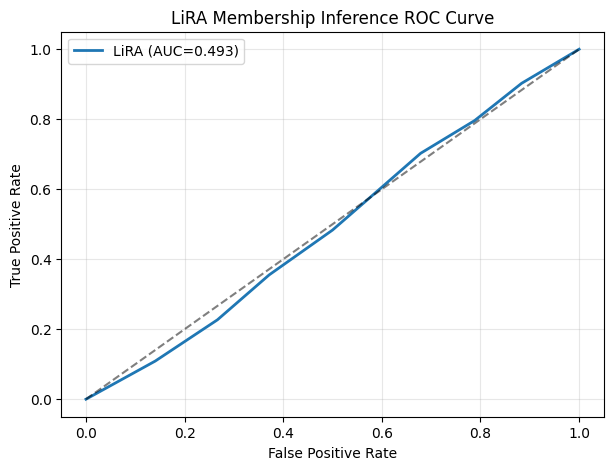

In [6]:
# Section 6: Analyze and Visualize LiRA Results
auc_lira = roc_auc_score(is_member, lira_scores)
fpr, tpr, _ = roc_curve(is_member, lira_scores)

print(f"LiRA ROC-AUC: {auc_lira:.4f}")
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'LiRA (AUC={auc_lira:.3f})', lw=2)
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LiRA Membership Inference ROC Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
